In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import warnings
import xgboost as xgb
import plotly.express as px

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_validate

from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')

import joblib
import pickle

In [ ]:
dfIranian = pd.read_csv("https://archive.ics.uci.edu/static/public/563/data.csv")

dfEsp = dfIranian.rename(columns={
    'Call  Failure': 'Fallos_Llamadas',
    'Complains' : 'Quejas',
    'Subscription  Length': 'Meses_permanencia',
    'Charge  Amount': 'Cargo ',
    'Seconds of Use': 'Total_segundos',
    'Frequency of use': 'Total_llamadas',
    'Frequency of SMS': 'Total_mensajes',
    'Distinct Called Numbers': 'Llamadas_numeros_distintos',
    'Age Group': 'Grupo_edades',
    'Tariff Plan': 'Plan_tarifa',
    'Status': 'Estado_clientes',
    'Age': 'Edad',
    'Customer Value': 'Valor_cliente',
    'Churn': 'Abandono'})

In [ ]:
corrMatrix = dfEsp.corr(numeric_only=True)
dfFilt = pd.DataFrame(corrMatrix[['Abandono']])*100
dfFilt

,Abandono
Fallos_Llamadas,-0.898737
Quejas,53.205296
Meses_permanencia,-3.258789
Cargo,-20.230536
Total_segundos,-29.893454
Total_llamadas,-30.333734
Total_mensajes,-22.075364
Llamadas_numeros_distintos,-27.886687
Grupo_edades,-1.455019
Plan_tarifa,-10.585294


In [ ]:
vl = 35
df2 = (dfFilt[(dfFilt['Abandono'] < vl) & (dfFilt['Abandono'] > -vl) & (dfFilt['Abandono']!=-1) & (dfFilt['Abandono']!=1)]).T
colFilt = df2.columns.tolist()
dfEnt = dfEsp[['Abandono']+colFilt]

In [ ]:
dfEnt.columns

Index(['Abandono', 'Fallos_Llamadas', 'Meses_permanencia', 'Cargo ',
       'Total_segundos', 'Total_llamadas', 'Total_mensajes',
       'Llamadas_numeros_distintos', 'Grupo_edades', 'Plan_tarifa', 'Edad',
       'Valor_cliente'],
      dtype='object')

In [ ]:
# Calcular la matriz de correlación completa (sin filtrar)
corrMatrix = dfEnt.corr(numeric_only=True)

# Crear el heatmap con todas las correlaciones
fig = px.imshow(
    corrMatrix,  # <-- Usar la matriz completa
    text_auto=True,  # Muestra los valores numéricos
    color_continuous_scale='RdBu',  # Escala de colores (rojo=negativo, azul=positivo)
    zmin=-1,  # Rango mínimo de correlación
    zmax=1,   # Rango máximo de correlación
    title='Matriz de Correlación'
)

# Ajustes de diseño
fig.update_layout(
    width=800,  # Ancho del gráfico
    height=800,  # Alto del gráfico (puedes ajustarlo)
    xaxis_title='Variables',
    yaxis_title='Variables',
    xaxis=dict(tickangle=90)  # Rotar etiquetas del eje X para mejor legibilidad
)

fig.show()

In [ ]:
dfEnt.columns

Index(['Abandono', 'Fallos_Llamadas', 'Meses_permanencia', 'Cargo ',
       'Total_segundos', 'Total_llamadas', 'Total_mensajes',
       'Llamadas_numeros_distintos', 'Grupo_edades', 'Plan_tarifa', 'Edad',
       'Valor_cliente'],
      dtype='object')

In [ ]:
#dfEnt = dfEnt[['Abandono','Plan_tarifa','Cargo ','Fallos_Llamadas','Grupo_edades']]

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
import numpy as np # Importar numpy para operaciones numéricas
from sklearn.model_selection import KFold, cross_validate # Importar KFold y cross_validate para validación cruzada (KFold es para regresión, StratifiedKFold para clasificación)
from sklearn.pipeline import Pipeline # Usamos Pipeline estándar ya que imbpipeline es específico de imblearn (para SMOTE/undersampling)
from sklearn.preprocessing import MinMaxScaler # Importar MinMaxScaler para escalar los datos
from sklearn.linear_model import LinearRegression # Importar LinearRegression

# Separación de características (X) y variable objetivo (y)
x = dfEnt.drop(columns=['Abandono'])
y = dfEnt['Abandono']

# División de los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

# --- Advertencia Importante: Regresión Lineal no es adecuada para una variable objetivo binaria (0 o 1) como 'Abandono'.
# --- Generalmente se usa Regresión Logística para problemas de clasificación como la predicción de abandono.
# --- El sobremuestreo (SMOTE) y las técnicas de balanceo de clases no son aplicables para Regresión Lineal.
# --- Por lo tanto, se omite el paso de balanceo y el uso de xTrainBal/yTrainBal directo en el entrenamiento del modelo.

# Mostrar el conteo de clases de la variable objetivo original (solo informativo, no se balancea para LinearRegression)
print(y.value_counts())
print(y.value_counts(normalize=True)*100)

# Inicializar el modelo de Regresión Lineal
# LinearRegression no tiene parámetros como max_iter o solver (son para modelos iterativos como LogisticRegression)
mdRgLnUnder = LinearRegression()

# Configurar la validación cruzada (KFold estándar para regresión)
kf = KFold(n_splits=5, shuffle=True, random_state=5)

# Crear una pipeline que escala los datos y luego aplica la Regresión Lineal
# Se elimina SMOTE de la pipeline ya que no es aplicable a la regresión
pipeline = Pipeline([('scaler', MinMaxScaler()), ('regresion_lineal', mdRgLnUnder)])

# Realizar la validación cruzada utilizando la pipeline y 'neg_mean_squared_error' como métrica de evaluación.
# Cuanto más cercano a 0 (o menos negativo), mejor. Para obtener MSE, se multiplica por -1.
cvResultados = cross_validate(pipeline, x, y, cv=kf, scoring='neg_mean_squared_error')
print(f'\nValidación cruzada con Escalado y Regresión Lineal (métrica: neg_mean_squared_error):')
print(f'  Scores de MSE Negativo: {cvResultados["test_score"]}')
print(f'  MSE Promedio: {-cvResultados["test_score"].mean():.4f}')
print(f'  Desviación Estándar del MSE: {cvResultados["test_score"].std():.4f}')
print(f'  RMSE Promedio (Raíz Cuadrada del Error Cuadrático Medio): {np.sqrt(-cvResultados["test_score"].mean()):.4f}')

# Entrenar el modelo de Regresión Lineal con los datos de entrenamiento escalados
# Se utiliza x_train y y_train originales, ya que no se aplica sobremuestreo.
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train) # Escalar las características de entrenamiento
mdRgLnUnder.fit(x_train_scaled, y_train)

print("\nModelo de Regresión Lineal entrenado exitosamente con datos escalados.")

Abandono
0    2655
1     495
Name: count, dtype: int64
Abandono
0    84.285714
1    15.714286
Name: proportion, dtype: float64

Validación cruzada con Escalado y Regresión Lineal (métrica: neg_mean_squared_error):
  Scores de MSE Negativo: [-0.10287548 -0.10167853 -0.10790172 -0.10039794 -0.10774786]
  MSE Promedio: 0.1041
  Desviación Estándar del MSE: 0.0031
  RMSE Promedio (Raíz Cuadrada del Error Cuadrático Medio): 0.3227

Modelo de Regresión Lineal entrenado exitosamente con datos escalados.


In [ ]:
import numpy as np
import pandas as pd # Asegurarse de que pandas esté importado para DataFrame

# Para LinearRegression, los coeficientes están directamente en .coef_ (no es una lista como en LogisticRegression con multi_class='ovr')
# Los coeficientes representan el cambio promedio en la variable dependiente por cada unidad de cambio en la variable independiente.
# Se usan las columnas de 'x' para los nombres de las características.
# Corrección: mdRgLnUnder.coef_ ya es un array 1D para la regresión lineal, por lo que no se necesita el [0].
importanciamdRgLnUnder = np.abs(mdRgLnUnder.coef_)
caracteImportmdRgLnUnder = pd.DataFrame({'Features': x.columns, 'Importancia': importanciamdRgLnUnder * 100}).round(2).sort_values(by='Importancia', ascending=False).reset_index(drop=True)

              precision    recall  f1-score   support

           0       0.42      0.02      0.04       783
           1       0.15      0.86      0.26       162

    accuracy                           0.17       945
   macro avg       0.29      0.44      0.15       945
weighted avg       0.38      0.17      0.08       945



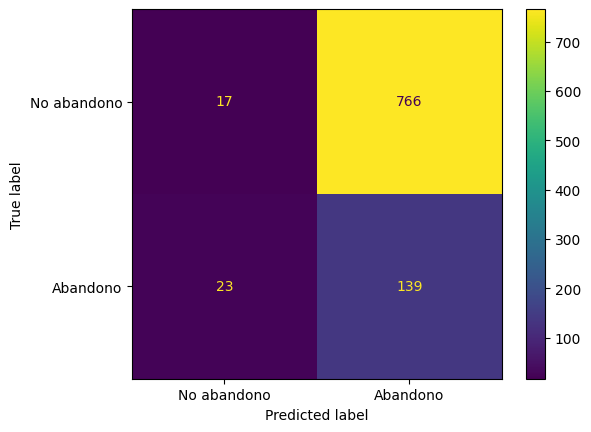

In [ ]:
yPrevisto = mdRgLnUnder.predict(x_test)
yPrevisto_binary = (yPrevisto > 0.5).astype(int) # Convertir predicciones continuas a binarias (0 o 1)
print(classification_report(y_test,yPrevisto_binary))
ConfusionMatrixDisplay.from_predictions(y_test,yPrevisto_binary, display_labels=['No abandono','Abandono'])
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score # Importar accuracy_score para calcular la exactitud de clasificación

# Obtener las predicciones del modelo de Regresión Lineal en el conjunto de prueba (x_test)
# yPrevisto contendrá valores continuos (flotantes).
# Nota: x_test debe ser escalado si el modelo fue entrenado con datos escalados
scaler = MinMaxScaler() # Reutilizar el scaler si fue entrenado en celdas previas
x_test_scaled = scaler.fit_transform(x_test)
yPrevisto = mdRgLnUnder.predict(x_test_scaled)

# Convertir las predicciones continuas en etiquetas binarias (0 o 1)
# Se usa un umbral de 0.5: si la predicción es >= 0.5, se clasifica como 1; de lo contrario, como 0.
yPrevisto_binary = (yPrevisto >= 0.5).astype(int)

# Calcular la exactitud del modelo utilizando las etiquetas binarias predichas y las reales
exactitud = accuracy_score(y_test, yPrevisto_binary)

# Imprimir la exactitud como porcentaje
print(f'La exactitud de clasificación del modelo en el conjunto de prueba es de: {exactitud:.4f} ({exactitud*100:.2f}%)')

# Comentario importante: La Regresión Lineal no es el modelo más adecuado para una variable objetivo binaria.
# Para problemas de clasificación, la Regresión Logística sería más apropiada ya que predice probabilidades directamente.
# Esta corrección calcula la exactitud de clasificación forzando la salida binaria del modelo de regresión lineal.

La exactitud de clasificación del modelo en el conjunto de prueba es de: 0.8392 (83.92%)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression # Importar LinearRegression
from sklearn.preprocessing import MinMaxScaler # Importar MinMaxScaler para escalar

# Asegurar que dfEnt esté disponible (asumiendo que fue cargado en celdas previas).
# Si dfEnt no está definido, puede que necesite ejecutar las celdas de carga y preparación de datos.

# Redefinir x e y
x = dfEnt.drop(columns=['Abandono'])
y = dfEnt['Abandono']

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# --- Advertencia Importante: Regresión Lineal no es adecuada para una variable objetivo binaria (0 o 1) como 'Abandono'.
# --- Generalmente se usa Regresión Logística para problemas de clasificación.
# --- El sobremuestreo (SMOTE) no es aplicable para Regresión Lineal, ya que es una técnica para balancear clases en clasificación.
# --- Por lo tanto, se eliminarán las partes relacionadas con SMOTE si existieran.

# Reinicializar y entrenar el modelo de Regresión Lineal
# LinearRegression no tiene random_state, max_iter ni solver como LogisticRegression.
mdRgLnUnder = LinearRegression()

# Escalar los datos de entrenamiento antes de entrenar el modelo
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)

mdRgLnUnder.fit(x_train_scaled, y_train)

print("Modelo de Regresión Lineal y datos de entrenamiento escalados están definidos.")

Modelo de Regresión Lineal y datos de entrenamiento escalados están definidos.


In [ ]:
# Cargar los datos originales desde la URL
dfIranian = pd.read_csv("https://archive.ics.uci.edu/static/public/563/data.csv")

# Renombrar columnas para mayor claridad en español
dfEsp = dfIranian.rename(columns={
    'Call  Failure': 'Fallos_Llamadas',
    'Complains' : 'Quejas',
    'Subscription  Length': 'Meses_permanencia',
    'Charge  Amount': 'Cargo ',
    'Seconds of Use': 'Total_segundos',
    'Frequency of use': 'Total_llamadas',
    'Frequency of SMS': 'Total_mensajes',
    'Distinct Called Numbers': 'Llamadas_numeros_distintos',
    'Age Group': 'Grupo_edades',
    'Tariff Plan': 'Plan_tarifa',
    'Status': 'Estado_clientes',
    'Age': 'Edad',
    'Customer Value': 'Valor_cliente',
    'Churn': 'Abandono'})

# Calcular la matriz de correlación solo para columnas numéricas
corrMatrix = dfEsp.corr(numeric_only=True)

# Filtrar correlaciones con 'Abandono' para quedarnos con las relevantes
dfFilt = pd.DataFrame(corrMatrix[['Abandono']])*100

# Definir el umbral de correlación
vl = 35

# Seleccionar las columnas con correlación dentro del rango (-vl, vl) excluyendo 1 y -1 (Abandono vs Abandono)
df2 = (dfFilt[(dfFilt['Abandono'] < vl) & (dfFilt['Abandono'] > -vl) & (dfFilt['Abandono']!=-1) & (dfFilt['Abandono']!=1)]).T

# Obtener la lista de columnas filtradas
colFilt = df2.columns.tolist()

# Crear el DataFrame de entrada dfEnt incluyendo 'Abandono' y las columnas filtradas
dfEnt = dfEsp[['Abandono']+colFilt]

print("DataFrame 'dfEnt' ha sido creado y está listo.")

DataFrame 'dfEnt' ha sido creado y está listo.


In [ ]:
import plotly.express as px # Importar plotly.express para visualizaciones interactivas

# Crear un histograma de la importancia de las características
varImportmdRgLnUnder = px.histogram(caracteImportmdRgLnUnder, x = 'Features', y='Importancia', text_auto = True)

# Actualizar las trazas para mostrar el texto de importancia con formato de porcentaje y fuera de las barras
varImportmdRgLnUnder.update_traces(texttemplate='%{y:.2f}%', textposition='outside')

# Actualizar el diseño del gráfico, añadiendo un título descriptivo
varImportmdRgLnUnder.update_layout(title='Importancia de variables después de entrenar modelo de Regresión Lineal con Undersample')

# Mostrar el histograma
varImportmdRgLnUnder.show()

In [ ]:
modelo_serializado = {'modelo': mdRgLnUnder}

with open('/content/mdRgLogjjoblib.dump', 'wb') as archivo:
    pickle.dump(modelo_serializado, archivo)

print("modelo serializado guardado como 'mdRgLogjoblib.dump'")

modelo serializado guardado como 'mdRgLogjoblib.dump'
